In [165]:
import pandas as pd
import os
from progressbar import ProgressBar
import numpy as np
import numpy as np
import re
import math
import spacy
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction import text
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

# 1. Preparing Data

In [115]:
def getData(file):
    data = pd.read_csv("../data/extracted/"+file,delimiter=',')
    moviename = ' '.join(file[:-4].split('_'))
#     print(moviename)
    return data, moviename

In [155]:
def getTrueLabels(df, moviename, labelsfile):

    
    movie = labelsfile[labelsfile['Movie']==moviename]
    if movie is not None:
        movie = movie[['Speaker', 'Gender']]
        movie['Speaker'] = movie['Speaker']
        temp = list(df['Speaker'])
        gen = []
#         print(temp, movie['Character'])
        count = 0
        for speaker in temp:
            try:
                gender = movie[movie['Speaker'].str.contains(speaker)]
                gender = list(gender['Gender'])
                gen.append(gender[0])
            except:
                gen.append(np.nan)
        df['Gender'] = gen
    return df

In [151]:
def convertToModelInputFormat(data):
    ans = []
    speakers = list(set(list(data['Speaker'])))
    for speaker in speakers:
        dialogues = data[data['Speaker']==speaker]
        dialogues = list(dialogues['Dialogue'])
        temp = []
        speaker = str(speaker)
        speaker = speaker.replace(".", "")
        speaker = speaker.replace("\"", "")
        speaker = speaker.replace("\t", "")
        temp.append(speaker)
        temp.append(dialogues)
        ans.append(temp)
    return ans

In [152]:
def test_train_split(entire_data):
    data = entire_data.copy()
    train_set = data.sample(frac=0.70, random_state=0)
    test_set = data.drop(train_set.index)
    train_set_labels = train_set.pop('Gender')
    test_set_labels = test_set.pop('Gender')
    return train_set, train_set_labels, test_set, test_set_labels

In [153]:
labelsfile = pd.read_csv('../data/Pre-processing_files/polygraph_matched_scriptid_title_gender.txt', 
                     delimiter='\t', names=['Match', 'Movie', 'Code', 'Speaker', 'Gender'])
labelsfile = labelsfile[labelsfile['Match']=='Matched']
labelsfile = labelsfile[['Movie', 'Speaker','Gender']]
labelsfile2 = pd.read_csv("../data/task1/entire_data2.csv",delimiter=',')
labelsfile = labelsfile.append(labelsfile2, ignore_index=True)

In [156]:
entire_data = pd.DataFrame([['Speaker', ['d1']]], columns=['Speaker', 'Dialogues'])
files = os.listdir('../data/extracted')
files.sort()
pbar = ProgressBar()
for file in pbar(files):
    if file[-4:] != ".csv":
        continue
    else:
        data, moviename = getData(file)
        ans = convertToModelInputFormat(data)
        df = pd.DataFrame(ans, columns = ['Speaker', 'Dialogues'])
        df = getTrueLabels(df, moviename, labelsfile)
        df['Movie'] = moviename
        entire_data = entire_data.append(df, ignore_index=True)

entire_data = entire_data.drop(0)
entire_data

100% |########################################################################|


,Speaker,Dialogues,Gender,Movie
1,pepe,"[Some people like the Colombian, but it all de...",male,10 Things I Hate About You
2,michael,"[You the new guy?, C'mon. I'm supposed to giv...",m,10 Things I Hate About You
3,mandelia,[The whole folio. All the plays.],female,10 Things I Hate About You
4,joey,[As opposed to a bitter self-righteous hag who...,m,10 Things I Hate About You
5,miss perky,[I'm sure you won't find Padua any different t...,female,10 Things I Hate About You
...,...,...,...,...
42839,sam tannick,"[Come., What do you have?, He was the best the...",male,xXx
42840,sterling,"[I hate to drop in unexpectedly., Time for a s...",male,xXx
42841,captain,"[Yes. I will cut the others loose, you must ru...",male,xXx
42842,kirill,"[Yorgi!, What's the problem?, What?, Nice and ...",male,xXx


In [157]:
null_url = pd.isnull(entire_data['Gender'])
temp = entire_data[null_url]

In [158]:
temp

,Speaker,Dialogues,Gender,Movie
593,"white - march 14, 2012","[Blue Revised - April 7, 2012 Pink Revised - A...",NaN,42
844,nan,[],NaN,A Prayer Before Dawn
845,elyias,"[Can make pain go `way..., Me name Elyias. You...",NaN,A Prayer Before Dawn
846,billy,"[I can't read Thai., GET ME THE EMBASSY!! GET...",NaN,A Prayer Before Dawn
847,doctor,[Going down?],NaN,A Prayer Before Dawn
...,...,...,...,...
39690,mr goudy,"[Objection. Hearsay., Let us restrict it to ""k...",NaN,True Grit
39693,mrs floyd,[Frank Ross's daughter. My poor child. My poor...,NaN,True Grit
40149,octobereighthninety-nine,[written by m.night.shyamalan],NaN,Unbreakable
40725,"july 27, 2000",[WARNER BROS. ...,NaN,Walk to Remember


In [199]:
entire_data.loc[entire_data['Speaker'] == '', 'Speaker'] = np.nan

In [200]:
# final_data = entire_data[entire_data.apply(lambda x: x.values.tolist() not in temp.values.tolist(), axis=1)]

In [203]:
entire_data.dropna(
    axis=0,
    how='any',
    thresh=None,
    subset=None,
    inplace=True
)

# 2. Making features

In [204]:
final_data = entire_data.rename(columns={"Speaker": "Name"})

In [205]:
final_data.loc[final_data['Gender'] == '?', 'Gender'] = "male"

In [206]:
# err

In [207]:
final_data.loc[final_data['Gender'] == "m", 'Gender'] = "male"
final_data.loc[final_data['Gender'] == "f", 'Gender'] = "female"
final_data

,Name,Dialogues,Gender,Movie
1,pepe,"[Some people like the Colombian, but it all de...",male,10 Things I Hate About You
2,michael,"[You the new guy?, C'mon. I'm supposed to giv...",male,10 Things I Hate About You
3,mandelia,[The whole folio. All the plays.],female,10 Things I Hate About You
4,joey,[As opposed to a bitter self-righteous hag who...,male,10 Things I Hate About You
5,miss perky,[I'm sure you won't find Padua any different t...,female,10 Things I Hate About You
...,...,...,...,...
42839,sam tannick,"[Come., What do you have?, He was the best the...",male,xXx
42840,sterling,"[I hate to drop in unexpectedly., Time for a s...",male,xXx
42841,captain,"[Yes. I will cut the others loose, you must ru...",male,xXx
42842,kirill,"[Yorgi!, What's the problem?, What?, Nice and ...",male,xXx


In [208]:
def numberOfMF(data):
    df = data.groupby('Gender')['Name'].count()
    print(df)
    df = pd.DataFrame({'Names': [df[0], df[1]]}, index=['Female', 'Male'])
    plot = df.plot.pie(subplots=True, figsize=(11, 6), colors = ['#ffb3e6','#c2c2f0'], 
                       autopct = "%.2f%%", labeldistance=1.15)
#   wedgeprops = {'linewidth':1.5, 'edgecolor':'white'}

Gender
female    15427
male      26699
Name: Name, dtype: int64


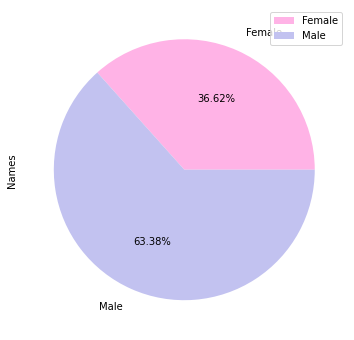

In [209]:
numberOfMF(final_data)

In [210]:
def checkEnd(name):
    if name[-1] in "aeiou":
        return "vowel"
    return "consonant"

final_data["EndsWith"] = final_data["Name"].apply(checkEnd)
final_data

,Name,Dialogues,Gender,Movie,EndsWith
1,pepe,"[Some people like the Colombian, but it all de...",male,10 Things I Hate About You,vowel
2,michael,"[You the new guy?, C'mon. I'm supposed to giv...",male,10 Things I Hate About You,consonant
3,mandelia,[The whole folio. All the plays.],female,10 Things I Hate About You,vowel
4,joey,[As opposed to a bitter self-righteous hag who...,male,10 Things I Hate About You,consonant
5,miss perky,[I'm sure you won't find Padua any different t...,female,10 Things I Hate About You,consonant
...,...,...,...,...,...
42839,sam tannick,"[Come., What do you have?, He was the best the...",male,xXx,consonant
42840,sterling,"[I hate to drop in unexpectedly., Time for a s...",male,xXx,consonant
42841,captain,"[Yes. I will cut the others loose, you must ru...",male,xXx,consonant
42842,kirill,"[Yorgi!, What's the problem?, What?, Nice and ...",male,xXx,consonant


In [215]:
def letterClass(name):
    name_list = [x for x in name]
    vowel_counter = 0
    consonant_counter = 0
    for letter in name_list:
        if letter in ['a','e','i','o','u']:
            vowel_counter+=1
        else:
            consonant_counter+=1
    
    return vowel_counter, consonant_counter

final_data['VowelCount'] = final_data['Name'].apply(lambda x: letterClass(x)[0])
final_data['ConsonantCount'] = final_data['Name'].apply(lambda x: letterClass(x)[1])

final_data

,Name,Dialogues,Gender,Movie,EndsWith,VowelCount,ConsonantCount
1,pepe,"[Some people like the Colombian, but it all de...",male,10 Things I Hate About You,vowel,2,2
2,michael,"[You the new guy?, C'mon. I'm supposed to giv...",male,10 Things I Hate About You,consonant,3,4
3,mandelia,[The whole folio. All the plays.],female,10 Things I Hate About You,vowel,4,4
4,joey,[As opposed to a bitter self-righteous hag who...,male,10 Things I Hate About You,consonant,2,2
5,miss perky,[I'm sure you won't find Padua any different t...,female,10 Things I Hate About You,consonant,2,8
...,...,...,...,...,...,...,...
42839,sam tannick,"[Come., What do you have?, He was the best the...",male,xXx,consonant,3,8
42840,sterling,"[I hate to drop in unexpectedly., Time for a s...",male,xXx,consonant,2,6
42841,captain,"[Yes. I will cut the others loose, you must ru...",male,xXx,consonant,3,4
42842,kirill,"[Yorgi!, What's the problem?, What?, Nice and ...",male,xXx,consonant,2,4


In [219]:
def getLength(name):
    return len(name)

final_data["Length"] = final_data["Name"].apply(getLength)

In [220]:
final_data

,Name,Dialogues,Gender,Movie,EndsWith,VowelCount,ConsonantCount,Length
1,pepe,"[Some people like the Colombian, but it all de...",male,10 Things I Hate About You,vowel,2,2,4
2,michael,"[You the new guy?, C'mon. I'm supposed to giv...",male,10 Things I Hate About You,consonant,3,4,7
3,mandelia,[The whole folio. All the plays.],female,10 Things I Hate About You,vowel,4,4,8
4,joey,[As opposed to a bitter self-righteous hag who...,male,10 Things I Hate About You,consonant,2,2,4
5,miss perky,[I'm sure you won't find Padua any different t...,female,10 Things I Hate About You,consonant,2,8,10
...,...,...,...,...,...,...,...,...
42839,sam tannick,"[Come., What do you have?, He was the best the...",male,xXx,consonant,3,8,11
42840,sterling,"[I hate to drop in unexpectedly., Time for a s...",male,xXx,consonant,2,6,8
42841,captain,"[Yes. I will cut the others loose, you must ru...",male,xXx,consonant,3,4,7
42842,kirill,"[Yorgi!, What's the problem?, What?, Nice and ...",male,xXx,consonant,2,4,6


In [227]:
def checkMoreVowels(data):
    data['vcCompare']= np.where(data['ConsonantCount'] == data['VowelCount'], 'equal', np.where(
    data['ConsonantCount'] > data['VowelCount'], 'moreConsonants', 'moreVowels')) 

checkMoreVowels(final_data)
final_data

,Name,Dialogues,Gender,Movie,EndsWith,VowelCount,ConsonantCount,Length,vcCompare
1,pepe,"[Some people like the Colombian, but it all de...",male,10 Things I Hate About You,vowel,2,2,4,equal
2,michael,"[You the new guy?, C'mon. I'm supposed to giv...",male,10 Things I Hate About You,consonant,3,4,7,moreConsonants
3,mandelia,[The whole folio. All the plays.],female,10 Things I Hate About You,vowel,4,4,8,equal
4,joey,[As opposed to a bitter self-righteous hag who...,male,10 Things I Hate About You,consonant,2,2,4,equal
5,miss perky,[I'm sure you won't find Padua any different t...,female,10 Things I Hate About You,consonant,2,8,10,moreConsonants
...,...,...,...,...,...,...,...,...,...
42839,sam tannick,"[Come., What do you have?, He was the best the...",male,xXx,consonant,3,8,11,moreConsonants
42840,sterling,"[I hate to drop in unexpectedly., Time for a s...",male,xXx,consonant,2,6,8,moreConsonants
42841,captain,"[Yes. I will cut the others loose, you must ru...",male,xXx,consonant,3,4,7,moreConsonants
42842,kirill,"[Yorgi!, What's the problem?, What?, Nice and ...",male,xXx,consonant,2,4,6,moreConsonants


In [229]:
def checkVCDifference(data):
    data['vcDifference']= data['ConsonantCount'] - data['VowelCount']

checkVCDifference(final_data)


In [230]:
final_data

,Name,Dialogues,Gender,Movie,EndsWith,VowelCount,ConsonantCount,Length,vcCompare,vcDifference
1,pepe,"[Some people like the Colombian, but it all de...",male,10 Things I Hate About You,vowel,2,2,4,equal,0
2,michael,"[You the new guy?, C'mon. I'm supposed to giv...",male,10 Things I Hate About You,consonant,3,4,7,moreConsonants,1
3,mandelia,[The whole folio. All the plays.],female,10 Things I Hate About You,vowel,4,4,8,equal,0
4,joey,[As opposed to a bitter self-righteous hag who...,male,10 Things I Hate About You,consonant,2,2,4,equal,0
5,miss perky,[I'm sure you won't find Padua any different t...,female,10 Things I Hate About You,consonant,2,8,10,moreConsonants,6
...,...,...,...,...,...,...,...,...,...,...
42839,sam tannick,"[Come., What do you have?, He was the best the...",male,xXx,consonant,3,8,11,moreConsonants,5
42840,sterling,"[I hate to drop in unexpectedly., Time for a s...",male,xXx,consonant,2,6,8,moreConsonants,4
42841,captain,"[Yes. I will cut the others loose, you must ru...",male,xXx,consonant,3,4,7,moreConsonants,1
42842,kirill,"[Yorgi!, What's the problem?, What?, Nice and ...",male,xXx,consonant,2,4,6,moreConsonants,2


In [231]:
def checkVowelCount(col):
    if col > 2:
        return 'more'
    return 'less'

def checkConsonantCount(col):
    if col > 3:
        return 'more'
    return 'less'

final_data["VowelCountClass"] = final_data["VowelCount"].apply(checkVowelCount)
final_data["ConsonantCountClass"] = final_data["ConsonantCount"].apply(checkConsonantCount)

In [232]:
def checkMoreVowels(col):
    if col == 'moreConsonants':
        return 'less'
    return 'more'

final_data["MoreVowels"] = final_data["vcCompare"].apply(checkMoreVowels)
final_data

,Name,Dialogues,Gender,Movie,EndsWith,VowelCount,ConsonantCount,Length,vcCompare,vcDifference,VowelCountClass,ConsonantCountClass,MoreVowels
1,pepe,"[Some people like the Colombian, but it all de...",male,10 Things I Hate About You,vowel,2,2,4,equal,0,less,less,more
2,michael,"[You the new guy?, C'mon. I'm supposed to giv...",male,10 Things I Hate About You,consonant,3,4,7,moreConsonants,1,more,more,less
3,mandelia,[The whole folio. All the plays.],female,10 Things I Hate About You,vowel,4,4,8,equal,0,more,more,more
4,joey,[As opposed to a bitter self-righteous hag who...,male,10 Things I Hate About You,consonant,2,2,4,equal,0,less,less,more
5,miss perky,[I'm sure you won't find Padua any different t...,female,10 Things I Hate About You,consonant,2,8,10,moreConsonants,6,less,more,less
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42839,sam tannick,"[Come., What do you have?, He was the best the...",male,xXx,consonant,3,8,11,moreConsonants,5,more,more,less
42840,sterling,"[I hate to drop in unexpectedly., Time for a s...",male,xXx,consonant,2,6,8,moreConsonants,4,less,more,less
42841,captain,"[Yes. I will cut the others loose, you must ru...",male,xXx,consonant,3,4,7,moreConsonants,1,more,more,less
42842,kirill,"[Yorgi!, What's the problem?, What?, Nice and ...",male,xXx,consonant,2,4,6,moreConsonants,2,less,more,less


In [233]:
def checkMoreDifference(col):
    if col > 1:
        return 'more'
    return 'less'

final_data["MoreDifferenceClass"] = final_data["vcDifference"].apply(checkMoreDifference)
final_data

,Name,Dialogues,Gender,Movie,EndsWith,VowelCount,ConsonantCount,Length,vcCompare,vcDifference,VowelCountClass,ConsonantCountClass,MoreVowels,MoreDifferenceClass
1,pepe,"[Some people like the Colombian, but it all de...",male,10 Things I Hate About You,vowel,2,2,4,equal,0,less,less,more,less
2,michael,"[You the new guy?, C'mon. I'm supposed to giv...",male,10 Things I Hate About You,consonant,3,4,7,moreConsonants,1,more,more,less,less
3,mandelia,[The whole folio. All the plays.],female,10 Things I Hate About You,vowel,4,4,8,equal,0,more,more,more,less
4,joey,[As opposed to a bitter self-righteous hag who...,male,10 Things I Hate About You,consonant,2,2,4,equal,0,less,less,more,less
5,miss perky,[I'm sure you won't find Padua any different t...,female,10 Things I Hate About You,consonant,2,8,10,moreConsonants,6,less,more,less,more
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42839,sam tannick,"[Come., What do you have?, He was the best the...",male,xXx,consonant,3,8,11,moreConsonants,5,more,more,less,more
42840,sterling,"[I hate to drop in unexpectedly., Time for a s...",male,xXx,consonant,2,6,8,moreConsonants,4,less,more,less,more
42841,captain,"[Yes. I will cut the others loose, you must ru...",male,xXx,consonant,3,4,7,moreConsonants,1,more,more,less,less
42842,kirill,"[Yorgi!, What's the problem?, What?, Nice and ...",male,xXx,consonant,2,4,6,moreConsonants,2,less,more,less,more


In [234]:
def getASCII(name):
    asciiVal = 0
    for x in name:
        asciiVal += ord(x)-97
    return asciiVal/len(name)

final_data["ASCIIval"] = final_data["Name"].apply(getASCII)

In [235]:
def makeBinary(data, cols, zero, one):
    for col in cols:
        data[col] = np.where((data[col] == zero),0,data[col])        
        data[col] = np.where((data[col] == one),1,data[col])
    return data

final_data = makeBinary(final_data, ['VowelCountClass', 'MoreVowels', 'MoreDifferenceClass'], 'less', 'more')
final_data = makeBinary(final_data, ['EndsWith'], 'consonant', 'vowel')
final_data = makeBinary(final_data, ['Gender'], 'male', 'female')

In [239]:
def dropColumns(data, collist):
    data = data.drop(columns=collist)
    return data

final_data2 = dropColumns(final_data, ['vcCompare', 'ConsonantCountClass', 'Gender', 'Name', 'Movie'])

In [240]:
final_data2

,Dialogues,EndsWith,VowelCount,ConsonantCount,Length,vcDifference,VowelCountClass,MoreVowels,MoreDifferenceClass,ASCIIval
1,"[Some people like the Colombian, but it all de...",1,2,2,4,0,0,1,0,9.500000
2,"[You the new guy?, C'mon. I'm supposed to giv...",0,3,4,7,1,1,0,0,6.285714
3,[The whole folio. All the plays.],1,4,4,8,0,1,1,0,6.375000
4,[As opposed to a bitter self-righteous hag who...,0,2,2,4,0,0,1,0,12.750000
5,[I'm sure you won't find Padua any different t...,0,2,8,10,6,0,0,1,6.100000
...,...,...,...,...,...,...,...,...,...,...
42839,"[Come., What do you have?, He was the best the...",0,3,8,11,5,1,0,1,2.727273
42840,"[I hate to drop in unexpectedly., Time for a s...",0,2,6,8,4,0,0,1,12.000000
42841,"[Yes. I will cut the others loose, you must ru...",0,3,4,7,1,1,0,0,8.142857
42842,"[Yorgi!, What's the problem?, What?, Nice and ...",0,2,4,6,2,0,0,1,10.833333
